# Creating regressors and design matrices for fMRI tasks

This unit covers
* How basic regressors are made for fMRI models
* Modulated regressors
* Brief overview of modeling response times (RTs)
* Adding the temporal derivative regressors
* Assessing collinearity in your design matrix


This covers a lot of material and if you'd like to go through it more slowly, I have a series of videos on level 1 modeling (time series modeling) of fMRI data on [a MumfordBrainStats playlist](https://www.youtube.com/playlist?list=PLB2iAtgpI4YFA39EWrvo44rPABcAm7VpY).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from nilearn.glm.first_level import compute_regressor, make_first_level_design_matrix
from nilearn.glm.contrasts import expression_to_contrast_vector
cb_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
sns.set_palette(cb_color_cycle)


### The basics of convolution

The fMRI time courses  we analyze are based on Blood Oxygen Level Dependent (BOLD) signal.  Basically neurons fire and oxygen is sent to them via the bloodstream with some extra oxygen.  This is not an instantaneous event, but can take a few seconds to occur, meaning a single "blip" of a neuron will yield a BOLD signal that looks like the following plot.  You'll see that when specifying the information about the neuronal signal that is hypothesized the onset time (10s), duration (0s for an instantaneous event) and magnitude (1 unit) are specified instead of creating a neuronal time course and feeding that into ``compute_regressor``. The ``spm`` option will be described shortly and ``frame_times`` is the time resolution of the BOLD data.  Here there are 50s of data with a time resolution of .2s.

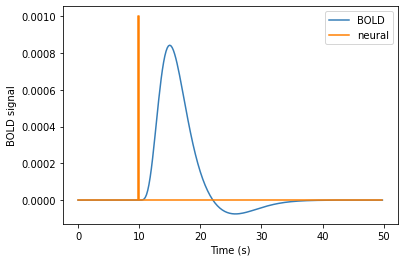

In [2]:
frame_times = np.arange(0, 50, .2)
#Stimulus a 10s, that is instantaneous (0s long) with an amplitude of 1
neural_signal_info = np.array([[10], [0], [1]])
bold_from_short_stimulus, _ = compute_regressor(neural_signal_info,
                                             'spm',
                                             frame_times)
neural_signal = np.zeros(frame_times.shape)
neural_signal[frame_times == neural_signal_info[0,0]] = .001
plt.plot(frame_times, bold_from_short_stimulus, label='BOLD')
plt.step(frame_times, neural_signal, label='neural')
plt.plot
plt.xlabel('Time (s)')
plt.ylabel('BOLD signal')
plt.legend()
plt.show()

There are a few important things to note about the hypothesized BOLD signal.  First, there's always some sort of scaling done by the software after convolution and it varies by software, so don't read much into why the peak is around .0008.  It doesn't really matter unless you want to convert your signal estimates to percent signal change, but that's for another day.  Second it takes about 6 seconds for the BOLD signal to fully build up.  Last, there's a post-stimulus undershoot where the signal dips below baseline before returning to baseline.  For our purposes here it doesn't matter why this is happening, only that it does happen and if we want our models to be accurate, we're better off including it.  

Now, the option we chose, `spm`, corresponds to the SPM HRF is a combination of 2 gamma functions, one gives the main peak and the other gives the undershoot.  Some software packages (FSL and likely AFNI) have a single gamma option, which does not have a post stimulus undershoot.  It is a bad idea to use a single gamma HRF because it can tend to overestimate the signal magnitude and it is noticeable in the results.  Nilearn doesn't have a single gamma, so I won't be illustrating it here.

The other option in Nilearn is the ``glover`` HRF, which is also a double gamma.  We tend to use the `spm` option, but it likely won't make much of a difference in practice.

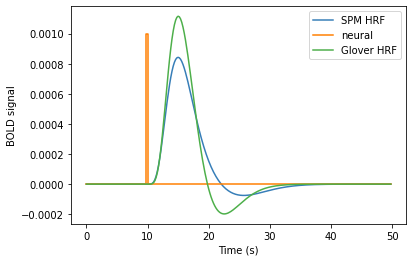

In [3]:
glover_hrf_bold_from_short_stimulus, _ = compute_regressor(neural_signal_info,
                                             'glover',
                                             frame_times)
plt.plot(frame_times, bold_from_short_stimulus, label='SPM HRF')
plt.step(frame_times, neural_signal, label='neural')
plt.plot(frame_times, glover_hrf_bold_from_short_stimulus, label='Glover HRF')
plt.plot
plt.xlabel('Time (s)')
plt.ylabel('BOLD signal')
plt.legend()
plt.show()

## Linear Time Invariance
So, what does ``compute_regressor`` do?  It takes the neuronal signal (orange) and smooshes it together with the HRF shape using an operation called convolution.  If you like equations, this is what it does with the neural signal over time, $n(t)$ and the hrf shape over time, $hrf(t)$:
$$convolved\_signal(t) = \sum_{m=-M}^tn(t-m)*hrf(m).$$
What does this mean?  This is a really sluggish signal, so what we measure right now is a summation of what is happening right now and remaining signal from the past.  

It is easier to understand with a neural signal that is longer than a blip.  I'm going through the summation backwards (starting at m=8)

$$BOLD\_estimate(8) = n(8-8)*hrf(8) + n(8-7)hrf(7) + n(8-6)hrf(6)+ n(8-5)hrf(5) + \dots$$
$$ = n(0)hrf(8) + n(1)hrf(7) + n(2)hrf(6) + n(3)hrf(5) + n(4)hrf(4) + n(5)hrf(3) + n(6)hrf(2) + n(7)hrf(1) + n(8)hrf(0)$$

So contribution from whatever the neuron is doing "right now" is very small since the value of the hrf at time 0 is 0 (see the example below).  What we see now is mostly signal that has built up from the past.  So, in a sense, the BOLD signal is living in the past and telling us nothing about the present time point.  The following plot illustrates convolution.  Note the HRF has been flipped from right to left (this accounts for the t-m part in the convolution operation).  The BOLD signal at 8 seconds is the sum of the heights of all of the stars, which are the products of the HRF height and the neural signal height (0 or 1).  You can see the largest contribution to the current signal, in this case, is a contribution from when the neuron was firing 4s ago.


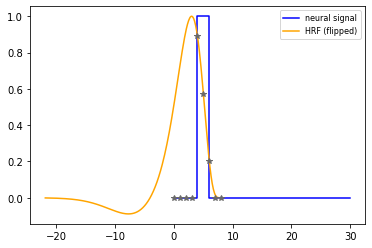

In [4]:
# illustrating convolution in 1s time resolution for time point t=8s
frame_times = np.arange(0, 30, .1)
bold_impulse, _ = compute_regressor(np.array([[0], [0], [1]]),
                                    'spm',
                                    frame_times)
neural_signal = np.zeros(frame_times.shape)
neural_signal[(frame_times>=4) & (frame_times<=6)] = 1

frame_times_flipped_shifted8s_bold = frame_times-(np.max(frame_times) - 8)
flipped_scaled_bold = bold_impulse[::-1]/np.max(bold_impulse)
plt.step(frame_times, neural_signal, color='blue', label='neural signal')
plt.plot(frame_times_flipped_shifted8s_bold, 
         flipped_scaled_bold, color='orange', label='HRF (flipped)')
for ind in range(9):
    plt.plot(ind, neural_signal[frame_times == ind]*
                flipped_scaled_bold[frame_times_flipped_shifted8s_bold == ind],
             '*', color='dimgrey')
plt.legend(loc='upper right', fontsize=8)
plt.show()



In terms of modeling the BOLD signal this we'll see the blurred nature of the signal will be problematic as it can cause collinearity in our models, or correlations between regressors, and is very important to consider when moving a behavioral task into the scanner.  You can get away with quick stimulus presentation in a behavioral study, but in the scanner those quick things are going to blur together and this might be an issue.  Concrete examples will be given shortly and expanded upon more in the next section on study design planning.

Note, you can and should use a much finer time resolution for the convolution operation!  Nilearn's default is to oversample by a factor of 50, meaning if the time resolution of your BOLD data is 1s, it will convolve in 1/50s and then downsample to the TR for modeling purpose.  This ensures the peak is captured well.  It is more important if your TRs are really long (>2s).

An important property of the BOLD signal is that the relationship between BOLD and neuronal signals tends to follow a Linear Time Invariant model, meaning if you shift the neuronal signal in time, the BOLD signal will show this same shift.  If you have two stimuli given one after the other, the resulting signal will be the sum of the two.  If this assumption did not hold, we would not be able to use the convolution operation to build our model regressors.  The following two plots illustrate these points.

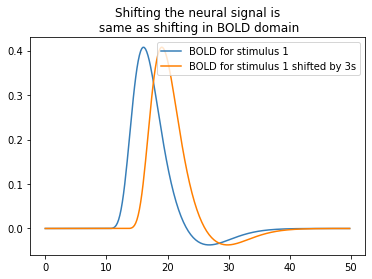

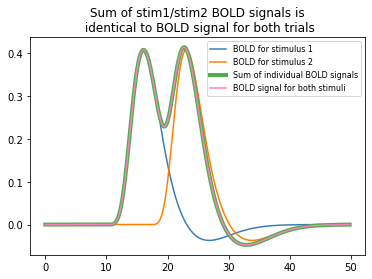

In [5]:
frame_times = np.arange(0, 50, .2)
stim1 = np.array([[10], [2], [1]])
stim2 = np.array([[17], [2], [1]])
stim1_shifted = np.array([[13], [2], [1]])

bold_stim1, _ = compute_regressor(stim1,'spm', frame_times)
bold_stim1_shifted, _ = compute_regressor(stim1_shifted,'spm', frame_times)
plt.plot(frame_times, bold_stim1, label="BOLD for stimulus 1")
plt.plot(frame_times, bold_stim1_shifted, label="BOLD for stimulus 1 shifted by 3s")
plt.legend()
plt.title('Shifting the neural signal is\n same as shifting in BOLD domain')
plt.show()

bold_stim2, _ = compute_regressor(stim2, 'spm', frame_times)
bold_stim1_stim2_sum = bold_stim1 + bold_stim2
stim1_2 = np.concatenate((stim1, stim2), axis=1)
bold_both_stim, _ = compute_regressor(stim1_2, 'spm', frame_times)

plt.plot(frame_times, bold_stim1, label="BOLD for stimulus 1")
plt.plot(frame_times, bold_stim2, label="BOLD for stimulus 2")
plt.plot(frame_times, bold_stim1_stim2_sum, linewidth=4, label="Sum of individual BOLD signals")
plt.plot(frame_times, bold_both_stim, label="BOLD signal for both stimuli")
plt.title('Sum of stim1/stim2 BOLD signals is\n identical to BOLD signal for both trials')
plt.legend(loc='upper right', fontsize=8)
plt.show()

#### Example of a modulated regressor

Sometimes tasks have conditions that we expect will modulate the BOLD activation in a linear fashion.  For example, each trial may have an amount won or lost and our hypothesis is that the BOLD activation will increase, linearly, with this value.  In this case the height of the neural response is simply modulated to match the values of interest.  The following is an example of this.

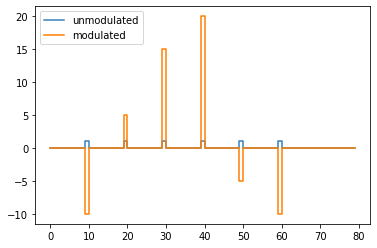

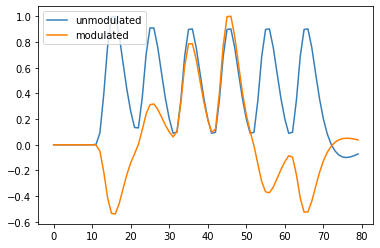

In [6]:
frame_times = np.arange(80)
onsets = np.array([[10, 20, 30, 40, 50, 60]])
vec_1s = np.ones((onsets.shape))
modulation = [[-10, 5, 15, 20, -5, -10]]
unmodulated = np.concatenate((onsets, vec_1s, vec_1s))
modulated = np.concatenate((onsets, vec_1s, modulation))

neural_unmod = np.zeros(len(frame_times))
neural_unmod[onsets] = 1

neural_mod = np.zeros(len(frame_times))
neural_mod[onsets] = modulation

plt.step(frame_times, neural_unmod, label='unmodulated')
plt.step(frame_times, neural_mod, label='modulated')
plt.legend(loc='upper left')
plt.show()



reg_unmodulated, _ = compute_regressor(unmodulated, 'spm', frame_times)
reg_modulated, _ = compute_regressor(modulated, 'spm', frame_times)

plt.plot(frame_times, reg_unmodulated/max(reg_unmodulated), label='unmodulated')
plt.plot(frame_times, reg_modulated/max(reg_modulated), label='modulated')
plt.legend(loc='upper left')
plt.show()

#### What models including RTs look like

Response times are an important consideration in your model if you have button presses.  The preprint to my RT paper is [here](https://www.biorxiv.org/content/10.1101/2023.02.15.528677v1), but there were numerous changes to the manuscript during review.  I'll update the link once I post the final version of the manuscript.

The basic idea is if the duration of the neural activation matches the RT, this will result in larger activation for the longer trials compared to the shorter ones (due to linear time invariance).  A trial that is twice as long as another will have twice the amount of BOLD signal, even when the magnitude of the neural signals is exactly the same.  The following example illustrates a Stroop task analogy where incongruent trials are longer than congruent.  Assuming the true activation magnitude is equal for both conditions, the BOLD magnitude is noticeably larger for the incongruent trials.  The implication is if RTs are ignored, these RT differences will fuel a bias in the incongruent-congruent contrast estimate, resulting in false positives.

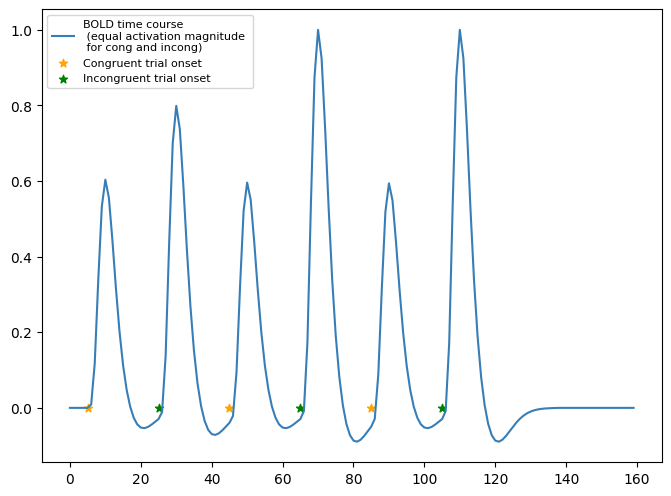

In [7]:
frame_times = np.arange(160)
onset_congruent = np.array([[5, 45, 85]])
onset_incongruent = np.array([[25, 65, 105]])
onsets_all = np.sort(np.concatenate((onset_congruent, onset_incongruent), axis=1))
rts = np.array([[.050, .080, .045, .09, .052, .083]])
rts_centered = rts - .07


congruent = np.concatenate((onset_congruent, np.ones((onset_congruent.shape)), np.ones((onset_congruent.shape))))
incongruent = np.concatenate((onset_incongruent, np.ones((onset_incongruent.shape)), np.ones((onset_incongruent.shape))))
rt_dur = np.concatenate((onsets_all, rts, np.ones((onsets_all.shape))))
rt_mod = np.concatenate((onsets_all, np.ones((onsets_all.shape)), rts_centered))

reg_congruent, _ = compute_regressor(congruent, 'spm', frame_times)
reg_incongruent, _ = compute_regressor(incongruent, 'spm', frame_times)
reg_rt_dur, _ = compute_regressor(rt_dur, 'spm', frame_times)
reg_rt_mod_centered, _ = compute_regressor(rt_mod, 'spm', frame_times)

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(frame_times, reg_rt_dur/max(reg_rt_dur), label='BOLD time course \n (equal activation magnitude \n for cong and incong)')
plt.scatter(onset_congruent, np.zeros(onset_congruent.shape), marker='*', color = 'orange', label='Congruent trial onset')
plt.scatter(onset_incongruent, np.zeros(onset_incongruent.shape),  marker='*', color = 'green', label='Incongruent trial onset')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The solution to the above problem is to add in a RT regressor to adjust the BOLD activation comparisons between conditions for the RT differences.  I'm greatly abbreviating the story here and would recommend reading the paper if you'd like the full details.  There are actually more negative repercussions that can result if one ignores RTs in the time series model and these problems cannot be repaired in higher level analyses.

There are two approaches one can take to adding RTs to the model.  One is to simply set the duration of the RT regressor to the individual trial RTs.  Call this model ConsDurRTDur
$$BOLD = \beta_0 + \beta_1 X_{incon} + \beta_2 X_{cong} + \beta_3X_{RTDur} + \epsilon.$$
In this model the interpretation of $\beta_1$  is the incongruent effect magnitude compared to baseline when the RT is 0 (similarly for $\beta_2$).  That's not super helpful, since you cannot have an RT of 0.  That said, it is highly unlikely that this is the primary contrast of interest.  We typically (as far as I know) only look at condition versus baseline contrasts as a reality check, not for heavy scientific purposes.  In the case of the contrast, $\beta_{incong} - \beta_{cong}$, the interpretation is fine, since this difference is the same for all RTs.  This model is, in fact, analogous to a two group comparison adjusting for a single confound.  For example, back in the regression section we compared Wisdom between two groups (does and does not do puzzles), adjusted for age.

For RTs <2s, there is going to be hardly any difference if the RT regressor is set up using duration, as was just outlined, versus using the parametric modulation.  After 2s, this linear relationship fails to hold, so DO NOT use this approach if ANY of your RTs are >2s.  The benefit of using parametric modulation is we can center the RTs prior to convolution.  Importantly, this centering should use the same centering constant for ALL subjects.  The value isn't really all that important, as long as it is within the range of RTs one would expect to find with the task.  You could, for example, use the mean RT for all subjects in your study or even the mean RT reported for that task in a different study.  To fully understand why, let's write out the regression formula and the parameter interpretation:
$$BOLD = \beta_0 + \beta_1 X_{incon} + \beta_2 X_{cong} + \beta_3X_{RTMod - .4s} + \epsilon.$$
Now $\beta_1$ has the interpretation of the incongruent activation versus baseline when the RT was .4s long.  Likewise for $\beta_2$ and $\beta_3$'s interpretation is unchanged.  This isn't a big deal in the case of the Stroop task, since it isn't likely that we'd study this contrast, but other tasks may have condition comparisons where some conditions involve RTs and some do not.  For example, in the Stop Signal task, comparing Correct Go to successful stop might use this strategy since only correct Go trials have an RT.  This task is actually sort of tricky to model and I believe it is much more complicated than this, but that will be left for another day.

Note the constant duration regressors ($X_{incon}$ and $X_{cong}$) can use 1s as the duration.  It doesn't really matter what is chosen as long as it is in the ballpark of the duration and <2s.


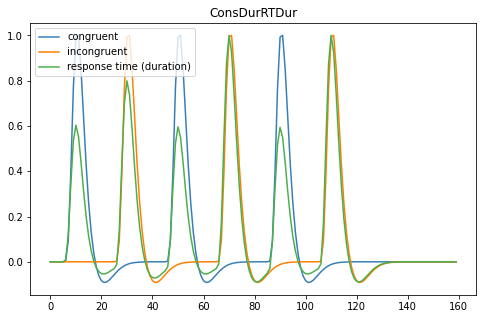

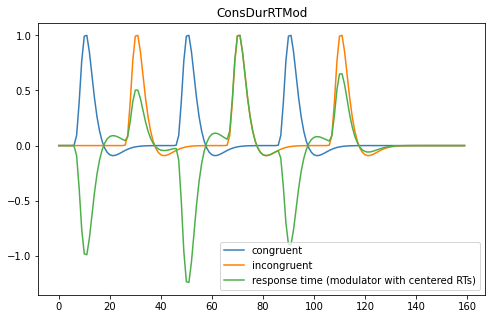

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(frame_times, reg_congruent/max(reg_congruent), label='congruent')
plt.plot(frame_times, reg_incongruent/max(reg_incongruent), label='incongruent')
plt.plot(frame_times, reg_rt_dur/max(reg_rt_dur), label='response time (duration)')
plt.title('ConsDurRTDur')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(frame_times, reg_congruent/max(reg_congruent), label='congruent')
plt.plot(frame_times, reg_incongruent/max(reg_incongruent), label='incongruent')
plt.plot(frame_times, reg_rt_mod_centered/max(reg_rt_mod_centered), label='response time (modulator with centered RTs)')
plt.title('ConsDurRTMod')
plt.legend(loc='lower right')
plt.show()

#### What the derivative does

It is common to enter the derivative terms into the model.  The reason is because the derivative (the change in signal per unit of change in time) can adjust for minor misspecifications of the onset of the trial or the time until when the peak occurs.  Since the HRF can change across the brain and across subjects, this is thought to be useful.  Although it is true that this will help the overall model fit better, it doesn't automatically repair the magnitude estimate used.  We typically still use the original regressor and ignore the derivative.  The repair requires combining the two through a nonlinear relationship (from the Calhoun reference below):
$$amplitude = sign(\hat\beta_{orig})\sqrt{\hat\beta_{orig}^2 + \hat\beta_{deriv}^2}.$$

We rarely actually do this, which makes me wonder whether it is worth it.  It does help reduce the residual, which is helpful, but we can discuss this further when we meet as a group.

I have encountered models where I've had to omit the derivative terms because of collinearity issues.  Although the derivative term is orthogonal to the term it is the derivative of, it can bump into regressors for other conditions.  This is typically only a problem in designs with really fast trial presentations.

The following illustration shows how the sum of the derivative and original regressor can effectively model a shift.  This shift can allow the true amplitude to be captured.  Otherwise, it will be underestimated as the peak will be assumed to be earlier or later.


More can be found in this paper
Calhoun, V.D., Stevens, M.C., Pearlson, G.D., Kiehl, K.A., 2004. fMRI analysis with the general linear model: removal of latency-induced amplitude bias by incorporation of hemodynamic derivative terms. NeuroImage 22, 252–257. https://doi.org/10.1016/j.neuroimage.2003.12.029


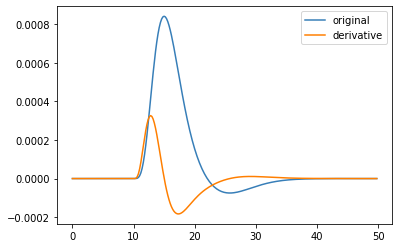

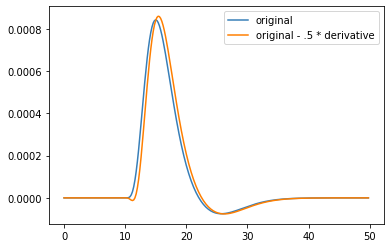

In [9]:
frame_times = np.arange(0, 50, .2)
neural_signal_info = np.array([[10], [0], [1]])
single_stim, names = compute_regressor(neural_signal_info,
                                             'spm + derivative',
                                             frame_times, con_id='single_stim')

plt.plot(frame_times, single_stim[:,0], label='original')
plt.plot(frame_times, single_stim[:,1], label='derivative')
plt.legend(loc='upper right')
plt.show()

plt.plot(frame_times, single_stim[:,0], label='original')
plt.plot(frame_times, single_stim[:,0] - .5 *single_stim[:,1], label='original - .5 * derivative')
plt.legend(loc='upper right')
plt.show()

#### Collinearity


It should be clear, due to the blurring of the signal, why stimuli presented very quickly will be tricky in an fMRI study.  A common occurrence in tasks is to present a stimulus that a subject observes, followed by a cue for the subject to give a response.  Let's assume one is interested in calculating a BOLD effect for when the brain is processing the stimulus as well as when they are shown the cue (when they respond).  For now, response time differences will be ignored, so we will assume it takes the same amount of time to respond on all trials.  

For our model, we will need a regressor that is what we predict the response will look like for the stimulus and then a second regressor that is a prediction for the cue response.  Since we use linear regression, the assumption is the signal in an active voxel will be a scalar multiple of some constant by the regressor we use (our prediction of the time course shape).

In [10]:
def make_desmat_2cond(nstim, name1='stimulus', name2='cue'):
    """
    All design matrices created assume there are 100s of time during which stimuli are presented
    and this time is split equally between the presentation of 2 conditions (stimlus/cue) that alternate. 
    Note, 20s of baseline time is added to the end for a total run time of 120s. 
    The amount of time between the stimlus offset and the cue onset equals the time between the
    cue offset and the next stimulus onset.  The durations of each are 1s long.
    Input:
      nstim: The total number of stimuli (must be divisible by 2), there will be nstim/2
               stimulus/cue pairs
    Output:
      desmat:  A design matrix (pandas 120 x 2) containing the 2 regressors (stimulus/cue)
    """
    if not nstim%2 == 0:
        raise ValueError('nstim must be an even number')
    frame_times = np.arange(120)
    all_onsets = np.linspace(0, 100, nstim)
    cond1_onsets = np.atleast_2d(all_onsets[::2])
    cond2_onsets = np.atleast_2d(all_onsets[1::2])
    vec_1s = np.ones((1, int(nstim/2)))

    #Assuming 1 for both the duration and amplitude
    cond1_reg_data = np.concatenate((cond1_onsets, vec_1s, vec_1s))
    cond2_reg_data = np.concatenate((cond2_onsets, vec_1s, vec_1s))

    reg_cond1, _ = compute_regressor(cond1_reg_data, 'spm', frame_times)
    reg_cond2, _ = compute_regressor(cond2_reg_data, 'spm', frame_times)

    desmat = pd.DataFrame({name1: reg_cond1[:,0], name2: reg_cond2[:,0]})
    return frame_times, desmat

Start off with 50 total condition presentations, which means there's about 1s between the offset of the stimulus and the onset of the cue.  Note the correlation between these two regressors is fairly high.

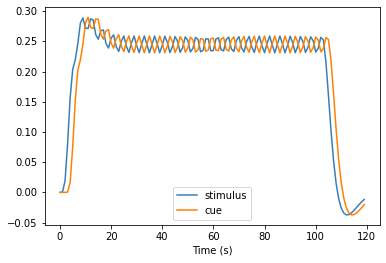

Pearson correlation of regressors
(0.9278461544754527, 2.2573537458409366e-52)


In [11]:
frame_times, desmat = make_desmat_2cond(50, name1='stimulus', name2='cue')
plt.plot(frame_times, desmat['stimulus'], label='stimulus')
plt.plot(frame_times, desmat['cue'], label='cue')
plt.legend()
plt.xlabel('Time (s)')
plt.show()

print('Pearson correlation of regressors')
print(pearsonr(desmat['stimulus'], desmat['cue']))

The above looks a bit dismal, but how high does the correlation need to be to cause problems?  The "problems" in the case of bad collinearity is high variable parameter estimates.  This is easy to see in the case of a perfect collinearity or when two regressors are identical.  Let's say the activation magnitude of the signal is 10, then this model estimation problem is akin to asking many people to give us two numbers that sum to 10.  Obviously there are an infinite number of solutions and this means the variability of value we're told is really high!  This is exactly what happens to the regression parameters:  The variance estimate of the parameter estimates is high.  High variance = low power, so this is a bad situation to be in.  

There's a nice measure called the Variance Inflation Factor (VIF) that quantifies this problem.  It has two really nice properties.  First, it overcomes the major limitation of using the correlation in that it can find collinearities that arise from the relationship between multiple regressors.  For example, the correlations between some regressors $X_1$, $X_2$ and $X_3$ may all be small, but the correlation between $X_1$ and $X_1+X_2$ could be really large.  Here's an example to illustrate this.

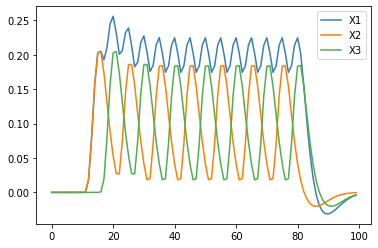

Pairwise correlations are not bad: cor(x1, x2)=0.673, cor(x1, x3)=0.673, cor(x2, x3)=-0.094
Correlation between x1 and x2+x3 is not fine: cor(x1, x2+x3)=1.0!


In [12]:
frame_times = np.arange(100)
onset_1 = np.array([[10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]])
onset_2 = np.array([[10, 20, 30, 40, 50, 60, 70]])
onset_3 = np.array([[15, 25, 35, 45, 55, 65, 75]]) 

dat_x1 = np.concatenate((onset_1, np.ones((onset_1.shape)), np.ones((onset_1.shape))))
dat_x2 = np.concatenate((onset_2, np.ones((onset_2.shape)), np.ones((onset_2.shape))))
dat_x3 = np.concatenate((onset_3, np.ones((onset_3.shape)), np.ones((onset_3.shape))))

x_1, _ = compute_regressor(dat_x1, 'spm', frame_times)
x_2, _ = compute_regressor(dat_x2, 'spm', frame_times)
x_3, _ = compute_regressor(dat_x3, 'spm', frame_times)

plt.plot(frame_times, x_1, label='X1')
plt.plot(frame_times, x_2, label='X2')
plt.plot(frame_times, x_3, label='X3')
plt.legend()
plt.show()

cor_x1_x2 = round(pearsonr(x_1[:,0], x_2[:,0])[0], 3)
cor_x1_x3 = round(pearsonr(x_1[:,0], x_3[:,0])[0], 3)
cor_x2_x3 = round(pearsonr(x_2[:,0], x_3[:,0])[0], 3)

cor_x1_sum_x2_and_x3 = round(pearsonr(x_1[:,0], x_2[:,0]+x_3[:,0])[0], 3)


print(f'Pairwise correlations are not bad: cor(x1, x2)={cor_x1_x2}, cor(x1, x3)={cor_x1_x3}, cor(x2, x3)={cor_x2_x3}')
print(f'Correlation between x1 and x2+x3 is not fine: cor(x1, x2+x3)={cor_x1_sum_x2_and_x3}!')




The VIF estimate is obtained for each regressor and uses the $R^2$ from the linear regression regressing the regressor of interest as a function of all of the other regressors.  So if the model has 4 regressors, this is the model that would be used to obtain the VIF for the first regressor (note, we do not use the dependent variable AT ALL).

$$X_1  = \beta_0 + \beta_1X_2 + \beta_2X_3 + \beta_3X_4 + \epsilon.$$

The $R^2$ from this model captures ($R^2_1$) whether any linear combination of regressors can create a new time course that is highly correlated with $X_1$.  The VIF is then given by
$$VIF_{X1} = \frac{1}{1-R_1^2}.$$
The goal is to have a VIF<4.  If it is above 10 you're in trouble.  Above 20 is really bad.  If you do have an elevated VIF for a regressor, you can run the regression from which the $R^2$ used the VIF came from and look at the individual parameter estimates from that model to see which combination of regressors is causing the issue.  Maybe you can omit those regressors or combine stimuli into a single regressor.  The solution typically depends on the cause of the collinearity and there isn't a blanket response for how to fix this issue.  I will say that this should *not* be a problem you're sorting out after you've collected the data.  Nothing is worse than discovering a bad study design after loads of time and money have been invested in collecting the data. We will address this in the next lesson that covers efficiency.

If there's nothing you can do and you're stuck with a high VIF you can (sort of) continue on your merry way.  The analyses are problematic and must be handled very very carefully and I would discourage moving forward with these designs.  Although the parameter estimates for individual subjects are highly variable and won't make much sense on their own, if you average these estimates over subjects you can get statistically valid results (type I errors *shouldn't* be elevated) with a big ding in power.  The big problem is it is *very* easy for the analysis to have outliers and outliers can increase type I errors.  So if this type of analysis is done, the data must be carefully checked for outliers, which is tricky to do in whole brain fMRI analyses.  For group averages it probably isn't too bad, but if one is looking at linear relationships between BOLD activation and subject-specific measures, like the linear relationship between the Stroop effect and age, if the stroop contrast had a really high VIF, this analysis will likely have outliers and the outliers can easily pull that regression line around.  So be careful if you do this.  If I reviewed your paper, I'd make you remove this analysis.  I don't feel it belongs in a publication, personally.  

Perhaps you just noticed I mentioned the VIF for a *contrast*, but I haven't yet explained how to do this. Although, up until writing this, I thought the VIF for contrasts was really useful, it can also hide inflated variances.  In fact, reparameterization of models can also hide this, which is illustrated below.

I'm not getting into the nitty gritty of the contrast-based VIF.  I "invented" it by using the ideas of effective regressors from a paper by Smith and others from (2007) (info below).  Basically it splits all of the regressors into two groups: regressors involved in the contrast and regressors not involved in the contrast.  The effective regressor step converts the set of regressors involved in the contrast into one regressor that yields the exact same parameter estimate as the contrast would (the effective regressors) and other, orthogonal, regressors that span the left over space the other contrast-related regressors spanned (the backups).  These are put together with the regressors that were not involved in the contrast to make a model where the parameter estimate (and inference) for the effective regressor exactly matches what one would get for the contrast.  This new model is then entered into the VIF calculation, but only to get the VIF for the effective regressor.  I think the "hiding" of the increase in variability may be due to the orthogonalizing bit that we must do here.  Although I don't show the exact math for how this is done, for the simple example below it is very easy to set up the effective regressor style model for the task looking at go and nogo trials.

Below is an example where the VIFs for the individual regressors isn't great, but the contrast of interest has a totally fine, but we'll see this doesn't mean we are out of the woods for that contrast.  After some data are simulated that illustrate that the variance is still actually quite high for the contrast estimate of go-nogo!  So the VIF is not a perfect measure.  I do believe the efficiency measures we cover in the next module can help avoid this situation, but as this is done in the study design period, we do not necessarily have data to create all of the regressors.  For example the RT regressor may cause issues with the condition-specific regressors if the RT differences are very large and this can impact the collinearity in a negative way.


Smith, S., Jenkinson, M., Beckmann, C., Miller, K., Woolrich, M., 2007. Meaningful design and contrast estimability in FMRI. NeuroImage 34, 127–136. https://doi.org/10.1016/j.neuroimage.2006.09.019


First some functions for estimating VIF.

In [13]:
def est_vif(desmat):
    '''
    General variance inflation factor estimation.  Calculates VIF for all 
    regressors in the design matrix
    input:
        desmat: design matrix.  Intercept not required.
    output:
      vif_data: Variance inflation factor for each regressor in the design matrix
                generally goal is VIF<5
    '''
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    desmat_with_intercept = desmat.copy()
    desmat_with_intercept['intercept'] = 1
    vif_data = pd.DataFrame()
    vif_data['regressor'] = desmat_with_intercept.columns.drop('intercept')
    vif_data['VIF'] = [variance_inflation_factor(desmat_with_intercept.values, i)
                          for i in range(len(desmat_with_intercept.columns))
                          if desmat_with_intercept.columns[i] != 'intercept']
    return vif_data


def get_eff_reg_vif(desmat, contrast):
    '''
    The goal of this function is to estimate a variance inflation factor for a contrast.
    This is done by extending the effective regressor definition from Smith et al (2007)
    Meaningful design and contrast estimability (NeuroImage).  Regressors involved
    in the contrast estimate are rotated to span the same space as the original space
    consisting of the effective regressor and and an orthogonal basis.  The rest of the 
    regressors are unchanged.
    input:
        desmat: design matrix.  Assumed to be a pandas dataframe with column  
             headings which are used define the contrast of interest
        contrast: a single contrast defined in string format
    output:
        vif: a single VIF for the contrast of interest  
    '''
    from scipy.linalg import null_space
    from nilearn.glm.contrasts import expression_to_contrast_vector
    contrast_def = expression_to_contrast_vector(contrast, desmat.columns)
    des_nuisance_regs = desmat[desmat.columns[contrast_def == 0]]
    des_contrast_regs = desmat[desmat.columns[contrast_def != 0]]

    con = np.atleast_2d(contrast_def[contrast_def != 0])
    con2_t = null_space(con)
    con_t = np.transpose(con)
    x = des_contrast_regs.copy().values
    q = np.linalg.pinv(np.transpose(x)@ x)
    f1 = np.linalg.pinv(con @ q @ con_t)
    pc = con_t @ f1 @ con @ q
    con3_t = con2_t - pc @ con2_t
    f3 = np.linalg.pinv(np.transpose(con3_t) @ q @ con3_t)
    eff_reg = x @ q @ np.transpose(con) @ f1
    eff_reg = pd.DataFrame(eff_reg, columns = [contrast])

    other_reg = x @ q @ con3_t @ f3 
    other_reg_names = [f'orth_proj{val}' for val in range(other_reg.shape[1])]
    other_reg = pd.DataFrame(other_reg, columns = other_reg_names)

    des_for_vif = pd.concat([eff_reg, other_reg, des_nuisance_regs], axis = 1)
    vif_dat = est_vif(des_for_vif)
    vif_dat.rename(columns={'regressor': 'contrast'}, inplace=True)
    vif_output = vif_dat[vif_dat.contrast == contrast]
    return vif_output


def get_all_contrast_vif(desmat, contrasts):
    '''
    Calculates the VIF for multiple contrasts
    input:
        desmat: design matrix.  Pandas data frame, column names must 
                be used in the contrast definitions
        contrasts: A dictionary of contrasts defined in string format
    output:
        vif_contrasts: Data frame containing the VIFs for all contrasts
    '''
    vif_contrasts = {'contrast': [],
                      'VIF': []}
    for key, item in contrasts.items():
        vif_out = get_eff_reg_vif(desmat, item)
        vif_contrasts['contrast'].append(vif_out['contrast'][0])
        vif_contrasts['VIF'].append(vif_out['VIF'][0]) 
    vif_contrasts = pd.DataFrame(vif_contrasts)
    return vif_contrasts     

#### Example of VIF and variance inflation using a Go/NoGo illustration

Here is a purposely horrible design where go and nogo trials alternate and are very close together.  To illustrate the limitations of VIF two models are constructed.  The first is the model with a regressor for go and a regressor for nogo.  The second models all trials as one regressor and uses a parametrically modulated regressor to model go (=1) and nogo(=-1).  These models are equivalent to each other and, in fact, when estimating the VIF for the go-nogo contrast in the first model, the code that constructs the effective regressor is actually recreating the second model.  Put another way, the effective regressor code uses the go-nogo regressor of the second model to estimate the VIF of the go-nogo contrast.

In [14]:
events = pd.DataFrame({'onset': np.linspace(2, 26,10),
          'duration': [1] * 10,
          'trial_type': ['go', 'nogo'] * 5,
          'amplitude': np.ones(10)})
events['go_minus_nogo'] = 1*(events['trial_type'] == 'go') - 1*(events['trial_type'] == 'nogo')
nogo_3col = events.loc[((events['trial_type'] == 'nogo')), ['onset', 'duration', 'amplitude'] ]
go_3col = events.loc[(events['trial_type'] == 'go') , ['onset', 'duration', 'amplitude'] ]

all_trials_3col = events[['onset', 'duration', 'amplitude']]
go_nogo_modulation_3col = events[['onset', 'duration', 'go_minus_nogo']]
go_nogo_modulation_3col.columns = ['onset', 'duration', 'amplitude']

go, go_names = compute_regressor(
        np.transpose(np.array(go_3col)),
        'spm + derivative',
        np.arange(50),
        con_id = 'go'
    ) 
nogo, nogo_names = compute_regressor(
        np.transpose(np.array(nogo_3col)),
        'spm + derivative',
        np.arange(50),
        con_id = 'nogo'
    ) 

all_trials, all_trials_names = compute_regressor(
        np.transpose(np.array(all_trials_3col)),
        'spm + derivative',
        np.arange(50),
        con_id = 'all_trials'
    ) 
go_nogo_modulation, go_nogo_modulation_names = compute_regressor(
        np.transpose(np.array(go_nogo_modulation_3col)),
        'spm + derivative',
        np.arange(50),
        con_id = 'go_minus_nogo'
    ) 
go_pd = pd.DataFrame(go, columns=go_names)
nogo_pd = pd.DataFrame(nogo, columns=nogo_names)
all_trials_pd = pd.DataFrame(all_trials, columns=all_trials_names)
go_nogo_modulation = pd.DataFrame(go_nogo_modulation, columns = go_nogo_modulation_names)

desmat1 = pd.concat([go_pd, nogo_pd], axis=1)
contrast1 = {'go - nogo': 'go - nogo',
            'task vs baseline': '.5*go + .5*nogo'}

desmat2 = pd.concat([all_trials_pd, go_nogo_modulation], axis=1)
contrast2 = {'go - nogo': '1* go_minus_nogo',
            'task vs baseline': '1*all_trials'}

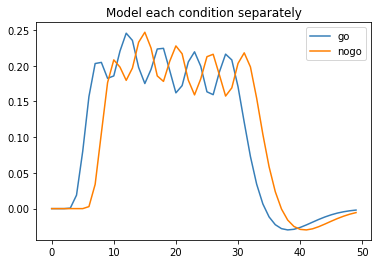

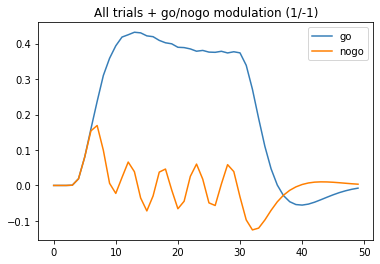

In [15]:
plt.plot(desmat1.loc[:,['go', 'nogo']])
plt.title('Model each condition separately')
plt.legend(['go', 'nogo'])
plt.show()

plt.plot(desmat2.loc[:,['all_trials', 'go_minus_nogo']])
plt.title('All trials + go/nogo modulation (1/-1)')
plt.legend(['go', 'nogo'])
plt.show()

Here are the VIFs for the regressors of the two models.  Based on this, one might conclude that desmat1 is much, much worse than desmat2 *but* the models are equivalent and one is not better than the other.

In [16]:
vif_desmat1 = est_vif(desmat1)
print(vif_desmat1)

vif_desmat2 = est_vif(desmat2)
print(vif_desmat2)

         regressor        VIF
0               go  10.120215
1    go_derivative   2.655307
2             nogo  10.178187
3  nogo_derivative   2.461170
                  regressor       VIF
0                all_trials  1.039190
1     all_trials_derivative  3.223080
2             go_minus_nogo  3.220226
3  go_minus_nogo_derivative  1.041926


Here are the contrast-specific VIFs for each model and you can see they are exactly the same.  Although the VIF for the go-nogo contrast looks good (<4) it actually is not good since the high variance of the individual go and nogo parameter estimates will sum to produce an even larger variance for the difference of the two.  

Suprisingly, if we made a contrast for the sum of go and nogo (go+nogo), the ill behavior of the collinearity *does* come out in the wash.  When two regressors are highly collinear what happens is one parameter estimate may be really large and then the other will balance this out by being really small.  The sum is actually right on target.  If it wasn't then our residual variances would not be the same in the different models.  This is shown in a simulation below.

In [17]:
vif_contrasts1 = get_all_contrast_vif(desmat1, contrast1)
print(vif_contrasts1)

vif_contrasts2 = get_all_contrast_vif(desmat2, contrast2)
print(vif_contrasts2)

          contrast       VIF
0        go - nogo  3.226822
1  .5*go + .5*nogo  1.039235
           contrast       VIF
0  1* go_minus_nogo  3.220226
1      1*all_trials  1.039190


Here 100 data sets are simulates where the true parameter estimates for go and nogo are 2 and 1, respectively.  The plots will illustrate how the variance is quite large for go-nogo, even though the VIF implied it would be okay.  On the flip side, the sum (go+nogo) counteracts the impact of collinearity on the parameter estimates and the variance is quite low on the sum.

In [18]:
nsims = 100

go_est =[]
nogo_est = []
go_nogo_est = []
sum_go_nogo = []

for i in range(nsims):
    bold = 2*desmat1['go'] + desmat1['nogo'] + np.random.normal(loc=0, scale=.1, size=len(desmat1['go']))
    desmat1['bold'] = bold
    model = smf.ols(formula='bold ~ go + nogo', data=desmat1).fit()
    go_loop = model.t_test([0, 1, 0])
    go_est.append(go_loop.effect)
    nogo_loop = model.t_test([0, 0, 1])
    nogo_est.append(nogo_loop.effect)
    go_nogo_loop = model.t_test([0, 1, -1])
    go_nogo_est.append(go_nogo_loop.effect)
    sum_go_nogo_loop = model.t_test([0, 1, 1])
    sum_go_nogo.append(sum_go_nogo_loop.effect)
    

sd_go = np.round(np.std(go_est), 3) 
sd_nogo = np.round(np.std(nogo_est), 3)
sd_go_minus_nogo = np.round(np.std(go_nogo_est), 3)
sd_go_plus_nogo = np.round(np.std(sum_go_nogo), 3)
print(f'Go sd of estimates over 100 data sets: {sd_go}')
print(f'No Go sd of estimates over 100 data sets: {sd_nogo}')
print(f'G0-NoGO sd of estimates over 100 data sets: {sd_go_minus_nogo}')
print(f'Go+NoGo sd of estimates over 100 data sets: {sd_go_plus_nogo}')

Go sd of estimates over 100 data sets: 0.272
No Go sd of estimates over 100 data sets: 0.277
G0-NoGO sd of estimates over 100 data sets: 0.53
Go+NoGo sd of estimates over 100 data sets: 0.144


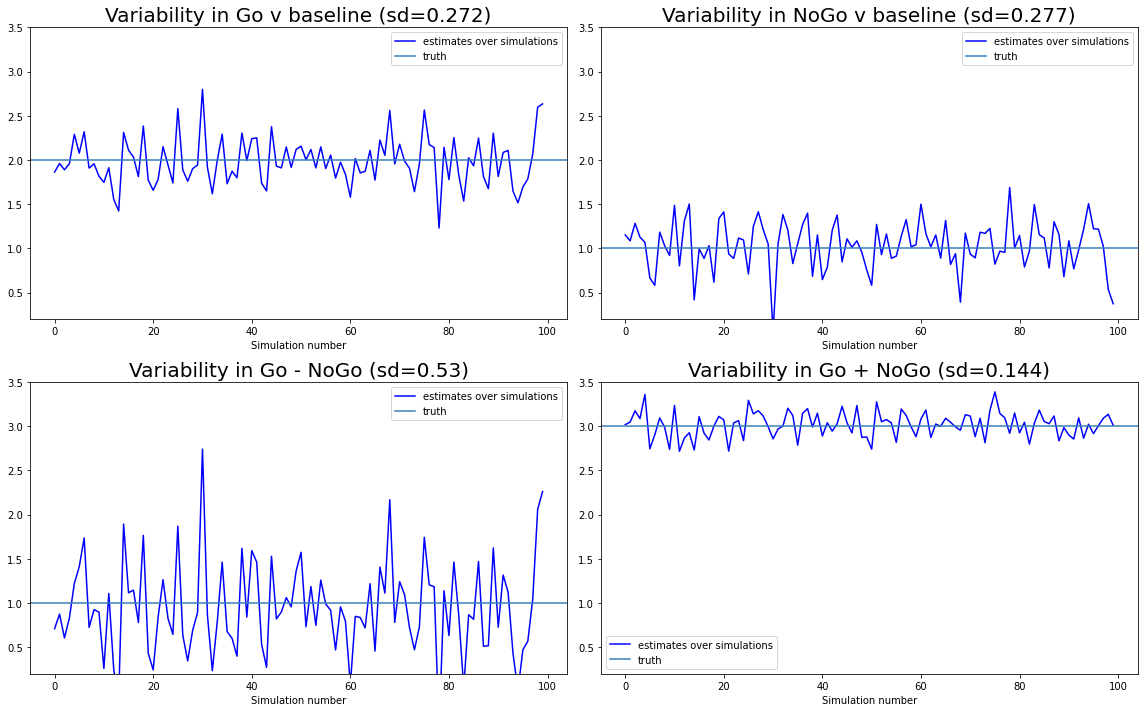

In [19]:
fig, axs = plt.subplots(2, 2, figsize = (16,10))

axs[0,0].plot(go_est, 'b', label='estimates over simulations')
axs[0,0].axhline(y=2, label='truth')
axs[0,0].set_xlabel('Simulation number')
axs[0,0].legend()
axs[0,0].set_ylim([.2, 3.5])
axs[0,0].set_title(f'Variability in Go v baseline (sd={sd_go})', fontsize=20)

axs[0,1].plot(nogo_est, 'b', label='estimates over simulations')
axs[0,1].axhline(y=1, label='truth')
axs[0,1].set_xlabel('Simulation number')
axs[0,1].legend()
axs[0,1].set_ylim([.2, 3.5])
axs[0,1].set_title(f'Variability in NoGo v baseline (sd={sd_nogo})', fontsize=20)

axs[1,0].plot(go_nogo_est, 'b', label='estimates over simulations')
axs[1,0].axhline(y=1, label='truth')
axs[1,0].set_xlabel('Simulation number')
axs[1,0].legend()
axs[1,0].set_ylim([.2, 3.5])
axs[1,0].set_title(f'Variability in Go - NoGo (sd={sd_go_minus_nogo})', fontsize=20)

axs[1,1].plot(sum_go_nogo, 'b', label='estimates over simulations')
axs[1,1].axhline(y=3, label='truth')
axs[1,1].set_xlabel('Simulation number')
axs[1,1].legend()
axs[1,1].set_ylim([.2, 3.5])
axs[1,1].set_title(f'Variability in Go + NoGo (sd={sd_go_plus_nogo})', fontsize=20)

fig.tight_layout()
plt.show()



Here I sort out this VIF issue.  If there's a high collinearity between two regressors (say stimulus A is always followed by stimulus B) we know the VIF for the A and B regressors will be high, but the VIF may not be high for the A-B contrast.  It seems if the low VIF for the A-B contrast makes sense.  If A and B have high collinearity, that implies there isn't much unique variance (unique to A and unique to B) and that seems to imply that there wouldn't be much variability for the A-B comparison.  In the simulations below I sort this out and show that if the high VIFs for A and B are driven by A and B themselves, then the VIF of the contrast is misleading.  On the other hand, if the collinearity is driven by another regressor in the model, then the VIF for the contrast is informative.  It helps to relate VIF to efficiency, which is a useful measure because it tells us the full story of how the variance estimate of a contrast estimate changes between designs (assuming the residual variance is the same).  The VIF is only a portion of this, which we will see can be problematic.

This is a sneak peek into the next set of materials that covers efficiency, but to understand the issues with VIF it helps to relate it to efficiency.  Take a model with $t$ observations given by 
$$Y = X\beta = \beta_0 + \beta_1X_1 + .... + \beta_nX_n,$$
where $X$ is a $t \times (n+1)$ matrix of the regressors (first column is all 1s, second column is $x_1$, etc) and $\beta$ is a $(n+1)$ vector of the betas.

To estimate $c\hat\beta$, for some contrast vector, $c$, we use
$$c\hat\beta = (X'X)^{-1}X'Y$$
and the variance estimate of the contrast estimate is given by
$$\widehat{Var}\left(c\hat\beta\right) = c(X'X)^{-1}c's^2,$$
where $s^2$ is the residual variance estimate.

The varaince is the product of the residual variance estimate and $c(X'X)c'^{-1}$, which doesn't depend on the data and tells us how the design of our study impacts the variability of the parameter estimates!  TThe inverse of this value is efficiency.  Specifically, for a given (row-vector) contrast, $c$, the efficiency is
$$Eff(c) = 1/c(X'X)^{-1}c'.$$
Efficiency doesn't have an interpretation on its own, like VIF does, but we can use it to rank design matrices and directly say "design A has a variance for contrast $c$ that is $Eff(c_B)/Eff(c_A)$ higher than design B".  This is pretty useful!  If we know one design is twice as efficient as another, the variance will be cut in half!  This is why efficiency is helpful in this scenario.  The VIF for the contrast comparison will likely always look good, but the efficiency might change.  If the efficiency doesn't change then we know the quality of the design isn't diminished. 

We can relate efficiency to the VIF.  The VIF applies to individual regressors, so assume we're either interested in the VIF of a specific regressor or we've already created the effective regressor that represents our contrast and we're focusing on the VIF of that regressor, the $i^{th}$ regressor.
$$\widehat{Var}\left(\hat\beta_i\right) =\frac{s^2}{(n-1)\widehat{Var}(x_i)}*VIF_i,$$
where $\widehat{Var}(x_i)$ is the variance of the regressor and $VIF_i$ is the VIF of the $i^{th}$ regressor.

Combining this with the efficiency definition gives:
$$eff(\beta_i) = \frac{(n-1)\widehat{Var}(x_i)}{VIF_i}$$
From this it is clear that the VIF cannot tell the full story about the variance (equivalently, the efficiency) since $\widehat{Var}(x_i)$ is also involved.  In the case of estimating the VIFs for contrasts, since the effective regressor for the contrast and some orthogonal basis functions that span the space that the contrast-related regressors span, involves some orthogonalization, the VIF, a measure of how orthogonal regressors are, can be misleading.  This is only the case if the regressors causing the collinearity are involved in the contrast.  This is the focus of the next simulation.

What I will do in the first set of simulations is keep the length of the run fixed and the number of trial fixed, but I will increase the ITI between the trials and look at the VIFs as well as the efficiency.  In this case the high VIFs for A and B are caused by A and B, themselves (they are highly correlated). 


In [20]:
def make_des(ntrials, iti, ntr):
    frame_times = np.arange(ntr)
    # assume trial presented for 1s
    onsets = np.cumsum(np.tile([1, iti], ntrials))
    onsets = onsets[1::2]
    onsets = np.concatenate((np.array([0]), onsets[:-1]))
    trial_type = np.tile([0, 1], int(ntrials/2))
    onsets_0 = onsets[trial_type == 0]
    onsets_1 = onsets[trial_type == 1]
    events_0 = pd.DataFrame({'onset': onsets_0,
                             'duration': [1] * int(ntrials/2),
                             'amplitude': [1] * int(ntrials/2)})
    events_1 = pd.DataFrame({'onset': onsets_1,
                             'duration': [1] * int(ntrials/2),
                             'amplitude': [1] * int(ntrials/2)})
    events_mod = pd.DataFrame({'onset': onsets,
                               'duration': [1] * ntrials,
                               'amplitude': np.tile([-1, 1], int(ntrials/2))})
    reg_0, names_0 = compute_regressor(
                        np.transpose(np.array(events_0)),
                        'spm',
                        frame_times,
                        con_id = 'reg_0'
                    ) 
    reg_1, names_1 = compute_regressor(
                        np.transpose(np.array(events_1)),
                        'spm',
                        frame_times,
                        con_id = 'reg_1'
                    )
    reg_mod, names_mod = compute_regressor(
                        np.transpose(np.array(events_mod)),
                        'spm',
                        frame_times,
                        con_id = 'reg_mod'
                    )
    desmat = pd.DataFrame({'intercept': np.ones(len(frame_times)),
                           'reg_0': reg_0[:,0],
                           'reg_1': reg_1[:,0]})
    contrast2 = {'reg_0': '1*reg_0',
            'reg_1': '1*reg_1',
            'reg_1-reg_0': '1*reg_1-1*reg_0'}
    vif_out = get_all_contrast_vif(desmat, contrast2)
    conmat = np.array([[0, 1, 0], [0, 0, 1], [0, -1, 1]])
    xtx_inv = np.linalg.inv(desmat.transpose() @ desmat)
    eff = 1/np.diag((conmat @ xtx_inv @ conmat.transpose()))
    return vif_out, eff, np.std(reg_mod)

In [21]:
ntrials = 30
ntr = 500
iti_vec = [.2, .5, .8, 1, 1.2, 1.5, 1.8, 2, 2.2, 2.5, 3]

vif_reg0 = []
vif_reg1 = []
vif_reg_diff = []
eff_reg0 = []
eff_reg1 = []
eff_reg_diff = []
std_reg_mod = []

for iti in iti_vec:
    vif_out, eff_out, std_reg_mod_loop = make_des(ntrials, iti, ntr)
    vif_reg0.append(vif_out['VIF'][0])
    vif_reg1.append(vif_out['VIF'][1])
    vif_reg_diff.append(vif_out['VIF'][2])
    eff_reg0.append(eff_out[0])
    eff_reg1.append(eff_out[1])
    eff_reg_diff.append(eff_out[2])
    std_reg_mod.append(std_reg_mod_loop)



The following plot shows the VIFs for A and B (they are identical) are very high for short ITIs while the VIF for the contrast is quite small for all ITIs.  The question is whether this is giving us the full picture about the overall impact of collinearity on the variance.

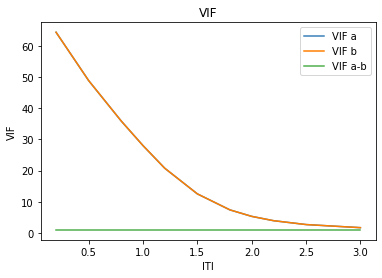

In [22]:
plt.plot(iti_vec, vif_reg0, label='VIF a')
plt.plot(iti_vec, vif_reg1, label='VIF b')
plt.plot(iti_vec, vif_reg_diff, label='VIF a-b')
plt.legend()
plt.xlabel('ITI')
plt.ylabel('VIF')
plt.title('VIF')
plt.show()

These efficiency plots reveal the truth about how the variance is impacted (recall efficiency is the inverse of the variance due to the design matrix).  If the efficiency doubles from one ITI to another, this implies the variance will be halved (which is great).  This shows the efficiency for the contrast, A-B, is definitely impacted by the low ITIs and improves as the ITI is increased.  Hence, the VIF was only showing us part of the story. 

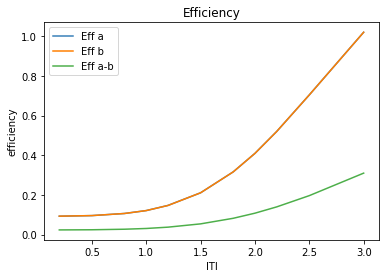

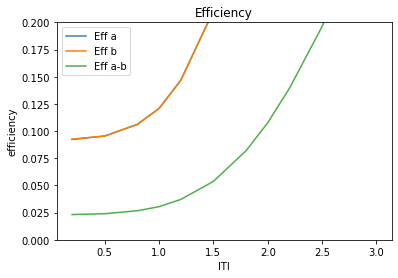

In [23]:
plt.plot(iti_vec, eff_reg0, label='Eff a')
plt.plot(iti_vec, eff_reg1, label='Eff b')
plt.plot(iti_vec, eff_reg_diff, label='Eff a-b')
plt.legend()
plt.title("Efficiency")
plt.xlabel('ITI')
plt.ylabel('efficiency')
plt.show()

plt.plot(iti_vec, eff_reg0, label='Eff a')
plt.plot(iti_vec, eff_reg1, label='Eff b')
plt.plot(iti_vec, eff_reg_diff, label='Eff a-b')
plt.legend()
plt.xlabel('ITI')
plt.ylabel('efficiency')
plt.title('Efficiency')
plt.ylim([0, .2])
plt.show()

The variance of the regressor is the missing piece.  Although the VIF remains constant, the variance of the regressor that represents the A-B contrast changes a lot.  Referring back to the equation relating efficiency to VIF, the relationship we see here makes sense.  

The moral of the story is if you have a high VIF for individual regressors that are being fed into a contrast, check to see what is driving the collinearity.  If it is the regressors of the contrast interfering with each other, then the VIF for the contrast is misleading.  In this case there isn't much you can do to remedy the problem if the data have already been collected.  Looking at the efficiency, in the case where data have been collected, isn't super informative in this case since efficiency is only used to compare 2 or more designs and you'd only have a single design at that point.  To avoid encountering this problem, be sure to run an efficiency search (next unit) prior to collecting your data.  In most cases this will ensure the regressors you are interested in are not going to be correlated with each other.  Instead, you only need to worry about the issue covered in the next bit of code: when subject-specific regressors (unknown prior to data collection) are involved in the collinearity.

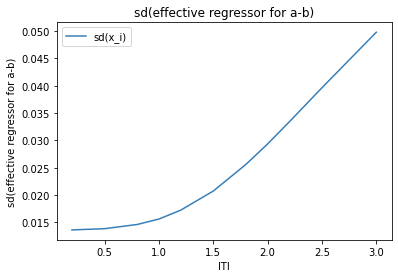

In [24]:
plt.plot(iti_vec, std_reg_mod, label='sd(x_i)')
plt.legend()
plt.xlabel('ITI')
plt.ylabel('sd(effective regressor for a-b)')
plt.title('sd(effective regressor for a-b)')
plt.show()


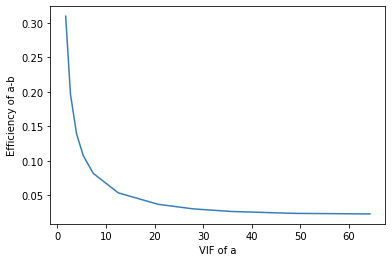

In [25]:
plt.plot(vif_reg1, eff_reg_diff)
plt.ylabel('Efficiency of a-b')
plt.xlabel('VIF of a')
plt.show()


In these simulations the two conditions (A and B) have regressors that are not correlated.  Instead the A and B regressors have a collinearity driven by an RT regressor.  As the RT difference between conditions increases, the collinearity will worsen.  

This is not intended to be prescriptive, as in "If my RT is less than a specific value I'll be okay".  This is simply an illustration.  I did not put time into selecting variances and RT distributions that were realistic.  Either way, there is a simple way to test this in your own data, which will be discussed after the simulation results.

In [26]:
def make_des_w_rt(ntrials, iti, ntr, rt_diff):
    frame_times = np.arange(ntr)
    # assume trial presented for 1s
    onsets = np.cumsum(np.tile([1, iti], ntrials))
    onsets = onsets[1::2]
    onsets = np.concatenate((np.array([0]), onsets[:-1]))
    trial_type = np.tile([0, 1], int(ntrials/2))
    onsets_0 = onsets[trial_type == 0]
    onsets_1 = onsets[trial_type == 1]
    rts_1 = np.random.uniform(low=.2, high=0.6, size=int(ntrials/2))
    rts_2 = np.random.uniform(low=.2+rt_diff, high=0.6+rt_diff, size=int(ntrials/2))
    rts = np.ones(len(onsets))
    rts[trial_type == 0] = rts_1
    rts[trial_type == 1] = rts_2
    rts_centered = rts - .5
    events_0 = pd.DataFrame({'onset': onsets_0,
                             'duration': [1] * int(ntrials/2),
                             'amplitude': [1] * int(ntrials/2)})
    events_1 = pd.DataFrame({'onset': onsets_1,
                             'duration': [1] * int(ntrials/2),
                             'amplitude': [1] * int(ntrials/2)})
    events_mod = pd.DataFrame({'onset': onsets,
                               'duration': [1] * ntrials,
                               'amplitude': np.tile([-1, 1], int(ntrials/2))})
    events_rt = pd.DataFrame({'onset': onsets,
                               'duration': [1] * ntrials,
                               'amplitude': rts_centered})
    reg_0, names_0 = compute_regressor(
                        np.transpose(np.array(events_0)),
                        'spm',
                        frame_times,
                        con_id = 'reg_0'
                    ) 
    reg_1, names_1 = compute_regressor(
                        np.transpose(np.array(events_1)),
                        'spm',
                        frame_times,
                        con_id = 'reg_1'
                    )
    reg_alltrials = reg_0[:,0] + reg_1[:,0]
    reg_mod, names_mod = compute_regressor(
                        np.transpose(np.array(events_mod)),
                        'spm',
                        frame_times,
                        con_id = 'reg_mod'
                    )
    reg_rtmod, names_mod = compute_regressor(
                        np.transpose(np.array(events_rt)),
                        'spm',
                        frame_times,
                        con_id = 'reg_rt'
                    )
    desmat = pd.DataFrame({'intercept': np.ones(len(frame_times)),
                           'reg_0': reg_0[:,0],
                           'reg_1': reg_1[:,0]})
    contrast = {'reg_0': '1*reg_0',
            'reg_1': '1*reg_1',
            'reg_1-reg_0': '1*reg_1-1*reg_0'}
    desmat_rt = pd.DataFrame({'intercept': np.ones(len(frame_times)),
                           'reg_0': reg_0[:,0],
                           'reg_1': reg_1[:,0],
                           'reg_rtmod': reg_rtmod[:,0]})
    contrast_rt = {'reg_0': '1*reg_0',
            'reg_1': '1*reg_1',
            'reg_1-reg_0': '1*reg_1-1*reg_0',
            'reg_rtmod': '1*reg_rtmod'}
    vif_out = get_all_contrast_vif(desmat, contrast)
    vif_out_rt = get_all_contrast_vif(desmat_rt, contrast_rt)
    conmat = np.array([[0, 1, 0], [0, 0, 1], [0, -1, 1]])
    conmat_rt = np.array([[0, 1, 0, 0], [0, 0, 1, 0], [0, -1, 1, 0]])
    xtx_inv = np.linalg.inv(desmat.transpose() @ desmat)
    xtx_inv_rt = np.linalg.inv(desmat_rt.transpose() @ desmat_rt)
    eff = 1/np.diag((conmat @ xtx_inv @ conmat.transpose()))
    eff_rt = 1/np.diag((conmat_rt @ xtx_inv_rt @ conmat_rt.transpose()))
    return vif_out, eff, vif_out_rt, eff_rt, np.std(reg_mod)

In [27]:
ntrials = 30
ntr = 500
iti = 2.2
rt_diff_vec = [.2, .5, .8, 1]

vif_reg0 = []
vif_reg1 = []
vif_reg_diff = []
eff_reg0 = []
eff_reg1 = []
eff_reg_diff = []
vif_reg0_rt = []
vif_reg1_rt = []
vif_reg_diff_rt = []
eff_reg0_rt = []
eff_reg1_rt = []
eff_reg_diff_rt = []
std_reg_mod = []

for rt_diff in rt_diff_vec:
    vif_out, eff_out, vif_out_rt, eff_out_rt, std_reg_mod_loop = make_des_w_rt(ntrials, iti, ntr, rt_diff)
    vif_reg0.append(vif_out['VIF'][0])
    vif_reg1.append(vif_out['VIF'][1])
    vif_reg_diff.append(vif_out['VIF'][2])
    eff_reg0.append(eff_out[0])
    eff_reg1.append(eff_out[1])
    eff_reg_diff.append(eff_out[2])
    vif_reg0_rt.append(vif_out_rt['VIF'][0])
    vif_reg1_rt.append(vif_out_rt['VIF'][1])
    vif_reg_diff_rt.append(vif_out_rt['VIF'][2])
    eff_reg0_rt.append(eff_out_rt[0])
    eff_reg1_rt.append(eff_out_rt[1])
    eff_reg_diff_rt.append(eff_out_rt[2])
    std_reg_mod.append(std_reg_mod_loop)

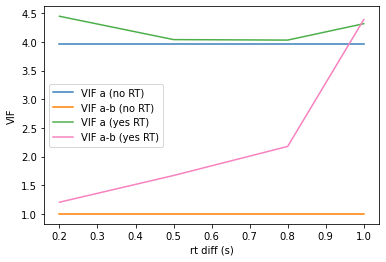

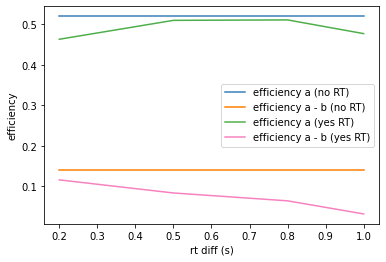

In [28]:
plt.plot(rt_diff_vec, vif_reg0, label="VIF a (no RT)")
plt.plot(rt_diff_vec, vif_reg_diff, label="VIF a-b (no RT)")
plt.plot(rt_diff_vec, vif_reg0_rt, label="VIF a (yes RT)")
plt.plot(rt_diff_vec, vif_reg_diff_rt, label="VIF a-b (yes RT)")
plt.xlabel('rt diff (s)')
plt.ylabel('VIF')
plt.legend()
plt.show()



plt.plot(rt_diff_vec, eff_reg0, label="efficiency a (no RT)")
plt.plot(rt_diff_vec, eff_reg_diff, label="efficiency a - b (no RT)")
plt.plot(rt_diff_vec, eff_reg0_rt, label="efficiency a (yes RT)")
plt.plot(rt_diff_vec, eff_reg_diff_rt, label="efficiency a - b (yes RT)")
plt.xlabel('rt diff (s)')
plt.ylabel('efficiency')
plt.legend()
plt.show()


The above plots show that in this case the VIF does a fine job picking up on the reduced efficiency.  Recall, the overall efficiency (or the variance) is what we really care about and the VIF is only part of that story.  In this case the variance of the effective regressor does not change across setttings (since it doesn't involve the RT regressor) and so the VIF tracks the efficiency changes.

If you find you have elevated VIFs for regressors involved in your contrasts and the VIFs are greatly reduced when RT is removed from the model, you have found the culprit.  Estimate the VIFs with and without RT in the model and take the ratio of the VIF(with RT)/VIF(without RT) and this will tell you how much the variance increases.  For example, if the ratio was 2, then the variance is doubled due to the collinearity, which is bad.  If it was 1.03, then there's only a 3\% increase in variance, which is fine (assuming the VIF for the no-RT model is less than 4).